In [1]:
from Run import Run
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from dk_utilities import get_digitizer_period

In [2]:
# look to find timing parameters to possibly allow t0 to be referenced to rf
# -> the bunches are probably too wide for this to be useful
# wide bunches helps veto events with 2 particles in a bunch -> quantify that

# work on improving t0 timing between digitizers

folder = "C:/Users/Karlen/Documents/temp/wtime/"

# run 464: no electron veto:
run_number = 464
#run_number = 745
run = Run.open_file(folder+"run_000"+str(run_number)+".dk")
config = run.config

if 'signal_times' in run.user:
    signal_times = run.user['signal_times']
else:
    signal_times = None

In [3]:
# look at separations of subsequent trigger times for all digitizers
triggerTimeDiffs = []
triggerCorrectedTimes = []
first_time = []
last_spill = -1
last_triggerTime = -1
overflow_count = []
for digi in range(3):
    triggerTimeDiffs.append([])
    triggerCorrectedTimes.append([])
    overflow_count.append(0)
    for ie,triggerTime in enumerate(run.times[digi]['triggerTime']):
        if digi != -1:
            if ie == 0:
                first_time.append(2**31 + run.times[digi]['triggerTime'][0])
                triggerCorrectedTime = 0
            else:
                if run.times[digi]['triggerTime'][ie] < run.times[digi]['triggerTime'][ie-1]:
                    overflow_count[digi] += 1
                triggerCorrectedTime = 2**31 + run.times[digi]['triggerTime'][ie] - first_time[digi] + overflow_count[digi]*(2**31)
            triggerCorrectedTimes[digi].append(triggerCorrectedTime)

        spill = run.times[digi]['spillNumber'][ie]
        if spill == last_spill:
            diff = triggerTime - last_triggerTime
        else:
            diff = -999
        triggerTimeDiffs[digi].append(diff)
        last_triggerTime = triggerTime
        last_spill = spill

C:\Users\karlen\AppData\Local\Temp\ipykernel_11452\678277899.py:25: RuntimeWarning: overflow encountered in ulong_scalars
  diff = triggerTime - last_triggerTime


[15215695738, 15215738918, 15215751740]

In [26]:
# check corrected times
period = 41.39
for ie in range(10):
    tc0 = triggerCorrectedTimes[0][ie]
    tc1 = triggerCorrectedTimes[1][ie]
    tc2 = triggerCorrectedTimes[2][ie]
    #if tc1!=tc0 or tc2!=tc0:
    print(ie)
    print(tc0,tc1,tc2,' -> ',tc0%period,tc1%period,tc1%period)
    print(tc1-tc0,tc2-tc0)

0
0 0 0  ->  0.0 0.0 0.0
0 0
1
938614 938616 938618  ->  12.96999999998711 14.96999999998711 14.96999999998711
2 4
2
1750042 1750046 1750046  ->  31.409999999975966 35.409999999975966 35.409999999975966
4 4
3
1856628 1856632 1856632  ->  38.1599999999745 0.7699999999745017 0.7699999999745017
4 4
4
2446846 2446852 2446854  ->  34.759999999966396 40.759999999966396 40.759999999966396
6 8
5
2539774 2539780 2539782  ->  0.8199999999651197 6.81999999996512 6.81999999996512
6 8
6
2828744 2828750 2828752  ->  27.22999999996115 33.22999999996115 33.22999999996115
6 8
7
2923562 2923568 2923570  ->  20.73999999995985 26.73999999995985 26.73999999995985
6 8
8
3076474 3076480 3076482  ->  38.07999999995775 2.689999999957749 2.689999999957749
6 8
9
3145268 3145276 3145278  ->  0.5099999999568041 8.509999999956804 8.509999999956804
8 10


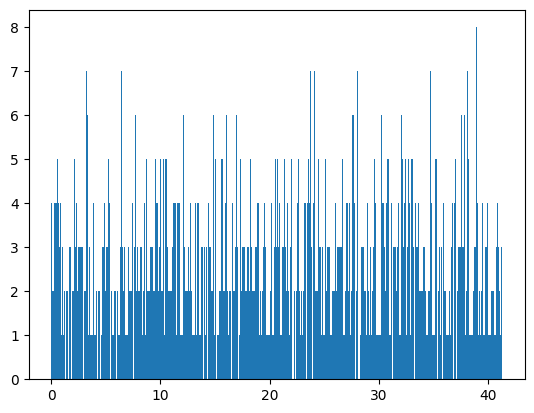

In [31]:
period = 41.39
offsets = []
for spill,ct in zip(run.times[0]['spillNumber'],triggerCorrectedTimes[0]):
    if spill == 0:
        offsets.append(ct%period)
plt.hist(offsets,bins=np.arange(0.,period,0.1))
#plt.hist(triggerTimeDiffs[0],bins=np.arange(0,100000,1000))
#plt.hist(triggerTimeDiffs[0],bins=np.arange(100000,100400,2))
plt.show()

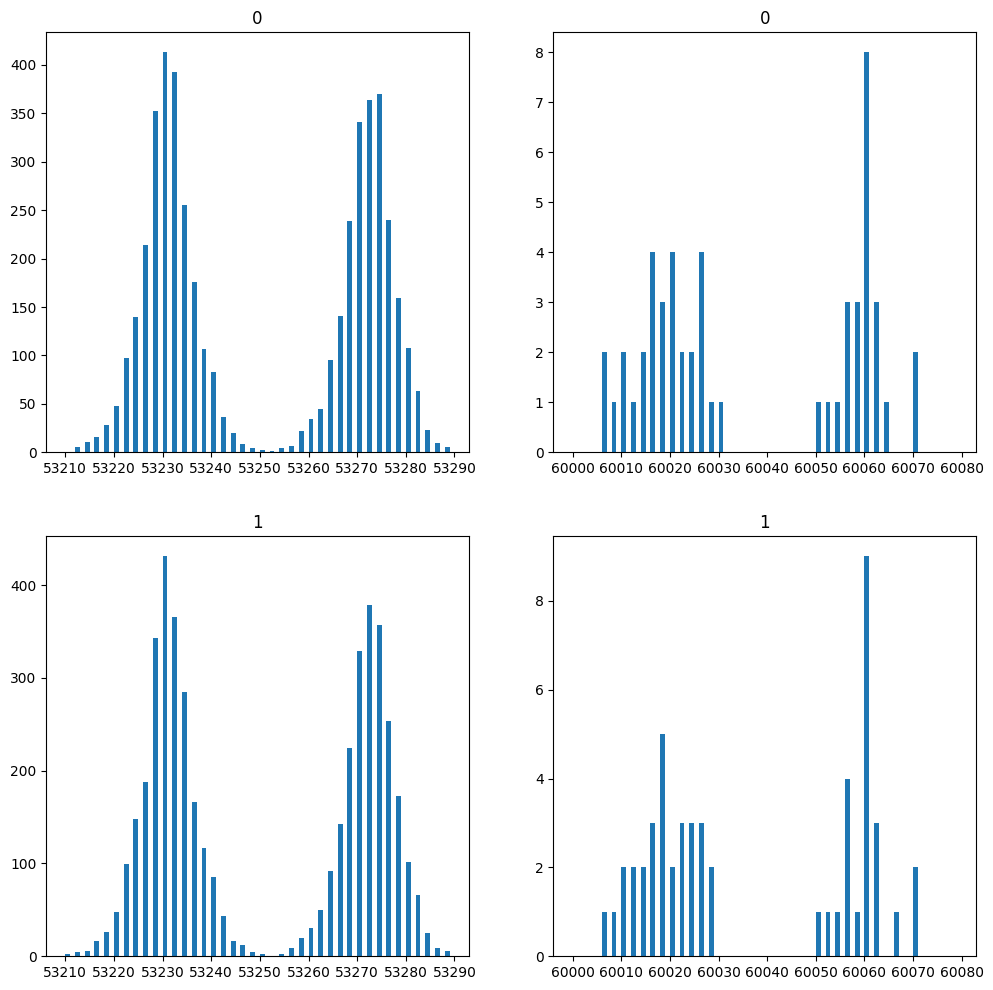

In [71]:
#print(triggerCorrectedTimes[1000:1010])
#print(run.times[0]['triggerTime'][1000:1010])
#plt.plot(triggerCorrectedTimes)
#plt.plot(triggerCorrectedTimes,run.times[0]['triggerTime'])
#plt.show()
#plt.hist(triggerTimeDiffs[0],bins=np.arange(100000,100400,2))
#plt.hist(triggerTimeDiffs[0],bins=np.arange(53000,53400,2))
#plt.hist(triggerTimeDiffs[0],bins=np.arange(53200,53400,1))
#plt.show()

digiss = [[0,0],[1,1]]
if run_number == 464:
    starts = [53210,60000]
else:
    starts = [5000,6000]

fig, axss = plt.subplots(2, 2, figsize=(12, 12))
for axs, digis in zip(axss,digiss):
    for ax, digi, start in zip(axs,digis,starts):
        ax.hist(triggerTimeDiffs[digi],bins=np.arange(start,start+80,1))
        ax.set_title(str(digi))
plt.show()


In [73]:
# simple ML fits:
starts = [53210, 53252]
width = 40
means = []

for start in starts:
    tds = []
    for td in triggerTimeDiffs[0]:
        if start <= td <= start+width:
            tds.append(td)
    means.append(np.mean(tds))
    print(start, np.mean(tds), np.std(tds), len(tds))

print(means[1]-means[0])

53210 53230.42922374429 5.492747119691638 2409
53252 53272.10175438596 5.4425384695292065 2280
41.672530641670164


In [15]:
periods = [41.666,41.358]
offsets = [28.,24., 20.]
for period in periods:
    for offset in offsets:
        shifted = []
        for spill,td in zip(run.times[0]['spillNumber'],triggerTimeDiffs[0]):
            if spill != -1 and 53200 < td < 63400:
                shifted.append((td-offset)%period - period/2.)

        var = np.std(shifted)
        mean = np.mean(shifted)
        print(period,offset,mean,var)

        #plt.hist(shifted,bins=np.arange(-period/2.,period/2.,0.5))
        #plt.title(str(period)+' '+str(offset))
        #plt.show()

41.666 28.0 6.673281570396762 10.20093192782704
41.666 24.0 5.7333235183837585 12.95283136127696
41.666 20.0 1.421482683174958 15.136614963787842
41.358 28.0 -3.1481395036219353 5.792215818261199
41.358 24.0 0.7187061452902928 5.759328843584202
41.358 20.0 4.491826644165012 5.872640253111555


In [20]:
for i_spill in range(5):
    tds = []
    for spill,td in zip(run.times[0]['spillNumber'],triggerTimeDiffs[0]):
        if spill == i_spill and 53200 < td < 63400:
            tds.append(td)
    m = get_digitizer_period(tds,41.4,20.)
    print(m.values)
    print(m.valid, m.accurate, m.fval)

<ValueView period=41.3893560266417 offset=22.398835858862007>
True True 26.50939371822828
<ValueView period=41.394910234575654 offset=18.011495909558093>
False True 31.438092154057873
<ValueView period=41.39709628910386 offset=13.830718391439412>
True True 27.86715131117363
<ValueView period=41.39505334614315 offset=14.07524092477305>
True True 28.668205502805282
<ValueView period=41.39874542615023 offset=12.339108637614764>
True True 28.42789134592224


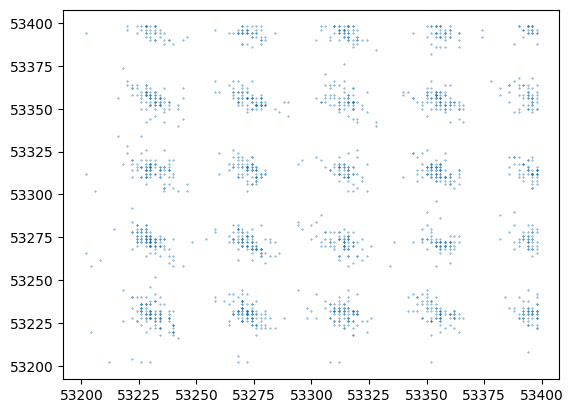

In [24]:
last_td = -999
td_curr = []
td_past = []
for td in triggerTimeDiffs[0]:
    if 53200 < last_td < 53400:
        if 53200 < td < 53400:
            td_curr.append(td)
            td_past.append(last_td)
    last_td = td

plt.scatter(td_past,td_curr, s=0.1)
plt.show()



(array([41.3892246 , 41.38944509, 41.38966559, 41.38988608, 41.39010658,
        41.39032707, 41.39054757, 41.39076806, 41.39098856, 41.39120905,
        41.39142955, 41.39165004, 41.39187054, 41.39209103, 41.39231153,
        41.39253202, 41.39275252, 41.39297301, 41.39319351, 41.393414  ,
        41.3936345 , 41.39385499, 41.39407549, 41.39429598, 41.39451648,
        41.39473697, 41.39495747, 41.39517796, 41.39539846, 41.39561895,
        41.39583945, 41.39605994, 41.39628044, 41.39650093, 41.39672143,
        41.39694192, 41.39716242, 41.39738291, 41.39760341, 41.39782391,
        41.3980444 , 41.3982649 , 41.39848539, 41.39870589, 41.39892638,
        41.39914688, 41.39936737, 41.39958787, 41.39980836, 41.40002886,
        41.40024935, 41.40046985, 41.40069034, 41.40091084, 41.40113133,
        41.40135183, 41.40157232, 41.40179282, 41.40201331, 41.40223381,
        41.4024543 , 41.4026748 , 41.40289529, 41.40311579, 41.40333628,
        41.40355678, 41.40377727, 41.40399777, 41.4

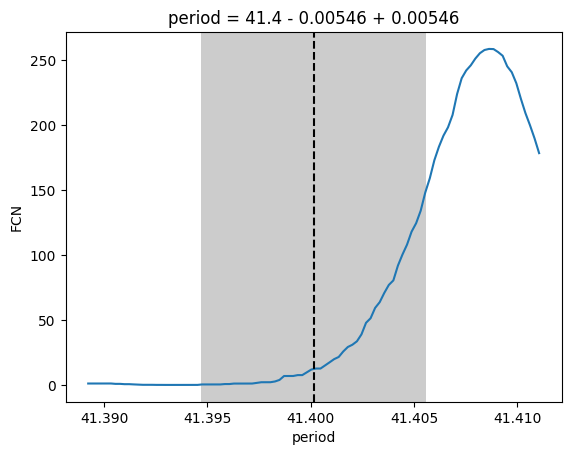

In [16]:
m.draw_profile('period')

(array([41.3909165 , 41.39099574, 41.39107499, 41.39115423, 41.39123348,
        41.39131272, 41.39139196, 41.39147121, 41.39155045, 41.3916297 ,
        41.39170894, 41.39178819, 41.39186743, 41.39194668, 41.39202592,
        41.39210517, 41.39218441, 41.39226366, 41.3923429 , 41.39242215,
        41.39250139, 41.39258064, 41.39265988, 41.39273913, 41.39281837,
        41.39289762, 41.39297686, 41.39305611, 41.39313535, 41.3932146 ,
        41.39329384, 41.39337309, 41.39345233, 41.39353158, 41.39361082,
        41.39369007, 41.39376931, 41.39384855, 41.3939278 , 41.39400704,
        41.39408629, 41.39416553, 41.39424478, 41.39432402, 41.39440327,
        41.39448251, 41.39456176, 41.394641  , 41.39472025, 41.39479949]),
 array([15.93240352, 16.10426209, 16.27612066, 16.44797923, 16.6198378 ,
        16.79169636, 16.96355493, 17.1354135 , 17.30727207, 17.47913064,
        17.65098921, 17.82284778, 17.99470634, 18.16656491, 18.33842348,
        18.51028205, 18.68214062, 18.85399919, 19

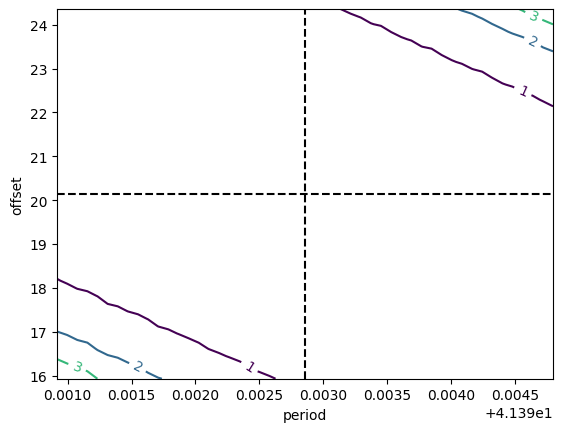

In [10]:
m.draw_contour('period','offset')

In [32]:
all_diffs = []
for spill,ct in zip(run.times[0]['spillNumber'],triggerCorrectedTimes[0]):
    if spill == 0:
        for spill2,ct2 in zip(run.times[0]['spillNumber'],triggerCorrectedTimes[0]):
            if spill2 ==0 and ct2 > ct:
                all_diffs.append(ct2-ct)

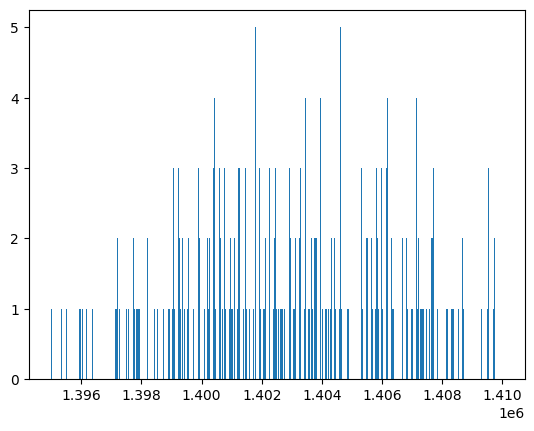

In [55]:
plt.hist(all_diffs,bins=np.arange(1.395e6,1.41e6,10))
plt.show()

In [114]:
special_time = []
special_triggerTimeDiffs = [[],[],[]]
#init_time =
for ie,triggerTimeDiff in enumerate(triggerTimeDiffs[0]):
    if 53210 < triggerTimeDiff < 53250:
        #special_time.append(run.times[0]['triggerTime'][ie]-run.times[0]['triggerTime'][0])
        special_time.append(triggerCorrectedTimes[ie])
        for digi in range(3):
            special_triggerTimeDiffs[digi].append(triggerTimeDiffs[digi][ie])

In [107]:
print(bin(np.min(run.times[0]['triggerTime'])),np.min(run.times[0]['triggerTime']))
print(bin(-1*2**31),-1*2**31)
print(bin(2**31 - np.min(run.times[0]['triggerTime'])),2**31 - np.min(run.times[0]['triggerTime']))

print(bin(np.max(run.times[0]['triggerTime'])),np.max(run.times[0]['triggerTime']))
print(bin(2**32 + np.max(run.times[0]['triggerTime'])),2**32 + np.max(run.times[0]['triggerTime']))
print(bin(2**31),2**31)
print(bin(2**31-run.times[0]['triggerTime'][0]),2**31-run.times[0]['triggerTime'][0])
print(bin(2**31-run.times[0]['triggerTime'][1]),2**31-run.times[0]['triggerTime'][1])

-0b1111111111111110111101010100001 -2147449505
-0b10000000000000000000000000000000 -2147483648
0b11111111111111110111101010100001 4294933153
-0b101001011001011 -21195
0b11111111111111111010110100110101 4294946101
0b10000000000000000000000000000000 2147483648
0b11010111111100011110010001101001 3622954089
0b11010111111000111001000111110011 3622015475


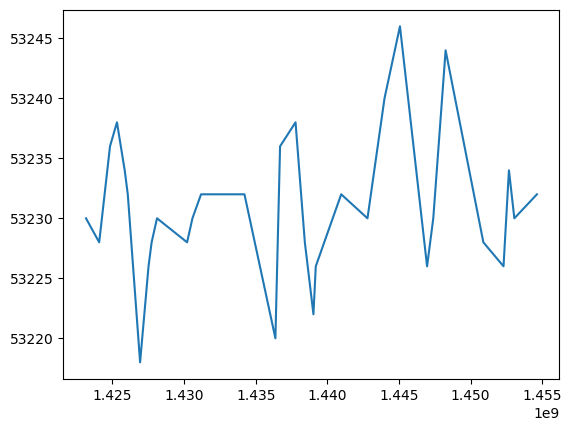

In [125]:
ts=[68,100]
plt.plot(special_time[ts[0]:ts[1]],special_triggerTimeDiffs[0][ts[0]:ts[1]])
plt.show()

In [6]:
# Use ch8 to find timing parameters, insist that both 8 and 9 have 1 peak
channels = [8,9]
digi = int(channels[0]/8)
spill = 0

spill_events = np.where(run.times[digi]['spillNumber']==spill)
ch_times = []
triggerTimes = []
triggerTime0 = None
for ie in spill_events[0]:
    if len(signal_times[channels[0]][ie]) == 1 and len(signal_times[channels[1]][ie]) == 1:
        if triggerTime0 is None:
            triggerTime0 = run.times[digi]['triggerTime'][ie]
        ch_times.append(signal_times[channels[0]][ie][0])
        triggerTimes.append(run.times[digi]['triggerTime'][ie]- triggerTime0)


In [4]:
# calculate the rms of the tch8rf dist
td = 8

trf = 305.1
ttt0 = 1.3

tdiff = []

#def rms(trf,ttt0):
m = int(trf/td)
delta = trf - m*td

t_offsets = [ttt0]
t_offset = ttt0
tx = 0
for ch_time, triggerTime in zip(ch_times[1:], triggerTimes[1:]):
    while tx < triggerTime - m:
        t_offset += delta
        if t_offset > td:
            t_offset -= td
            tx -= 1
        tx += m
    tdiff.append(triggerTime-tx)
    t_off_approx = t_offset + delta*(triggerTime-tx)/m
    if t_off_approx > td:
        t_off_approx -= td
    t_offsets.append(t_off_approx)





In [5]:
#fig, axs = plt.subplots(1, 1, figsize=(10, 6))
#plt.plot(triggerTimes[1:],tdiff)

In [6]:
#plt.hist(tdiff,bins=range(40))
#plt.show()

In [7]:
#spill = 8
for spill in range(52):
    channels = [8,9]
    digi = int(channels[0]/8)

    spill_events = np.where(run.times[digi]['spillNumber']==spill)
    ch_times = []
    triggerTimes = []
    triggerTimeDiffs = []
    triggerTime0 = None
    for ies,ie in enumerate(spill_events[0]):
        #if len(signal_times[channels[0]][ie]) == 1 and len(signal_times[channels[1]][ie]) == 1:
            if triggerTime0 is None:
                triggerTime0 = run.times[digi]['triggerTime'][ie]
            #ch_times.append(signal_times[channels[0]][ie][0])
            triggerTimes.append(run.times[digi]['triggerTime'][ie]- triggerTime0)
            if ies>0:
                triggerTimeDiffs.append(run.times[digi]['triggerTime'][ie]-run.times[digi]['triggerTime'][ie-1])

    #fig, axs = plt.subplots(1, 1, figsize=(10, 6))
    #plt.plot(triggerTimeDiffs[0:])
    #plt.show()

In [62]:
triggerTimes[0:5],triggerTimeDiffs[0:5],len(triggerTimes),len(triggerTimeDiffs)

([0, 37546, 75066, 112626, 150176],
 [37546, 37520, 37560, 37550, 37496],
 1388,
 1387)

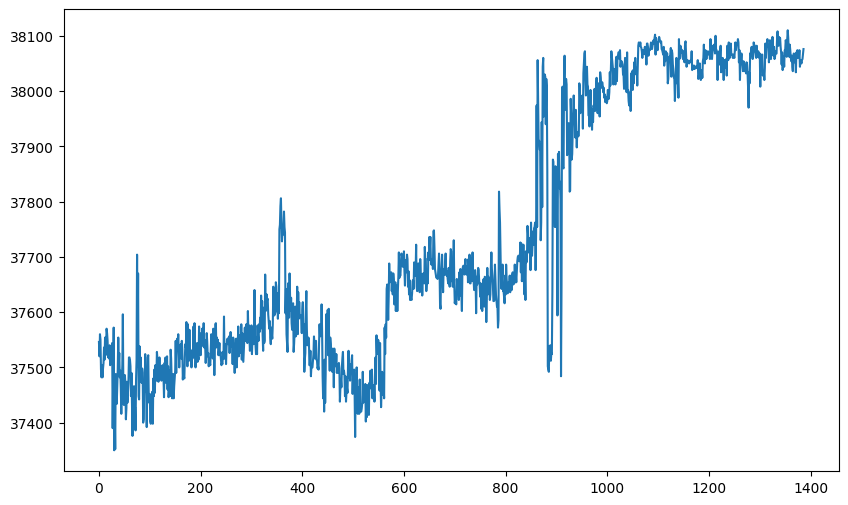

In [63]:
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
plt.plot(triggerTimeDiffs[0:])
plt.show()

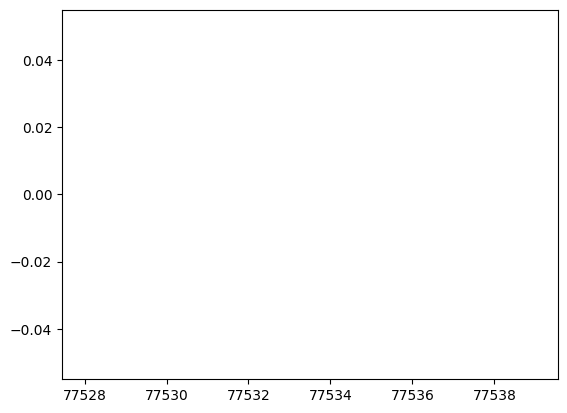

In [21]:
plt.hist(triggerTimeDiffs,range(77528,77540,1))
plt.show()

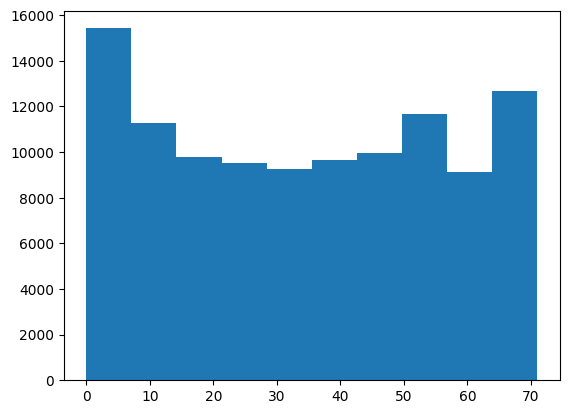

In [23]:
plt.hist(run.times[digi]['spillNumber'])
plt.show()